# Load chain

In [8]:
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol
import os
result_folder = "results/dev-init-relax-100/task_26_repeat-5_25000_2.0_298.0k_gaff-2.11"
sdf_file = os.path.join(result_folder, "init_chain.sdf")
smiles = ""
smiles_path = os.path.join(result_folder,"psmiles.txt")
with open(smiles_path,"r") as f:
    smiles = f.readline()
mol_H  = Chem.MolFromMolFile(sdf_file, removeHs=False)  # 保留H
mol_noH = Chem.RemoveHs(mol_H, updateExplicitCount=True)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Extract monomers & Calculate rigid transformation

In [9]:
# Compute monomer match index on polymer chain 
from utils.monomer_utils import extract_monomers
filled_index_clean, matches_H, matches_with_H,map_noH_to_H,keypoints,keypoints_poly = extract_monomers(sdf_file,smiles)

In [3]:
import numpy as np
from rdkit.Chem import rdchem
from utils.monomer_utils import compute_rigid_frame_from_three_atoms,compute_rigid_transforms_for_matches
# Compute rotation and transition
R_arr, t_arr = compute_rigid_transforms_for_matches(mol_H.GetConformer(),matches_H,keypoints)

In [4]:
import os
from rdkit import Chem
import json
from utils.monomer_utils import get_positions_from_indices,to_local_coords,extract_submol_by_atoms,save_monomers_to_sdf


monomer_dir = os.path.join(result_folder,"monomers")
save_monomers_to_sdf(mol_H, map_noH_to_H,matches_with_H, monomer_dir,keypoints_poly,R_arr,t_arr)

# Transform to global & Compose Monomer

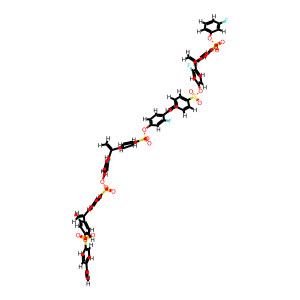

In [5]:
from utils.monomer_utils import to_global_coords,compose_monomers
from rdkit.Chem import Draw

## read R from file
R_arr = np.load(os.path.join(result_folder,"monomers","R_arr.npy"))
n_repeat = R_arr.shape[0]
## load monomers
from utils.monomer_utils import backbone2full,expand_with_attached_H
monomer_dir = os.path.join(result_folder,"monomers")
monomer_all_files = []
mols_all_H = []
mols_all_noH = []
map_noH_to_Hs = []
map_H_to_noHs = []
file_list = sorted(os.listdir(monomer_dir))
for item in file_list:
    if item.endswith(".sdf"):
        monomer_file = os.path.join(monomer_dir,item)
        monomer_all_files.append(monomer_file)
        suppl = Chem.SDMolSupplier(monomer_file, removeHs=False,sanitize=False)
        mol_H = suppl[0]
        mol_noH = Chem.RemoveHs(mol_H)
        mols_all_H.append(mol_H)
        mols_all_noH.append(mol_noH)
        map_noH_to_H = backbone2full(mol_H,mol_noH)
        map_H_to_noH = {v:k for k,v in map_noH_to_H.items()}
        map_noH_to_Hs.append(map_noH_to_H)
        map_H_to_noHs.append(map_H_to_noH)
t = np.zeros(3)
keypoints_json_path = os.path.join(result_folder,"monomers","keypoints.json")
keypoints_list = []
with open(keypoints_json_path,"r") as f:
    keypoints_list = json.load(f)
transformed_monomers = []
## compose monomers to polymers
for i in range(0,5):
    R =  R_arr[i]
    mol_H = mols_all_H[i]
    conf = mol_H.GetConformer()
    ## transform to global position
    local_positions = get_positions_from_indices(conf,[i for i in range(mol_H.GetNumAtoms())])
    n1,s1,n2,s2 = keypoints_list[i]
    global_positions = to_global_coords(local_positions,R_arr[i],t)
    conf.SetPositions(global_positions)
    
    ## calculate t
    if i != n_repeat-1:
        s2_pos = conf.GetAtomPosition(s2)
    t = np.array([s2_pos.x, s2_pos.y, s2_pos.z], dtype=float)
merged_mol, atom_map = compose_monomers(
    mols_all_H=mols_all_H,
    mols_all_noH=mols_all_noH,
    map_noH_to_Hs=map_noH_to_Hs,
    keypoints_json_path=keypoints_json_path
)
img = Draw.MolToImage(merged_mol, size=(300, 300))
img

mol_H:
  原子总数         = 142
  键总数           = 151
  不同键类型数量   = 3
  各类型键的分布：
    SINGLE: 76
    DOUBLE: 15
    AROMATIC: 60

merged_mol:
  原子总数         = 142
  键总数           = 151
  不同键类型数量   = 3
  各类型键的分布：
    SINGLE: 76
    DOUBLE: 15
    AROMATIC: 60



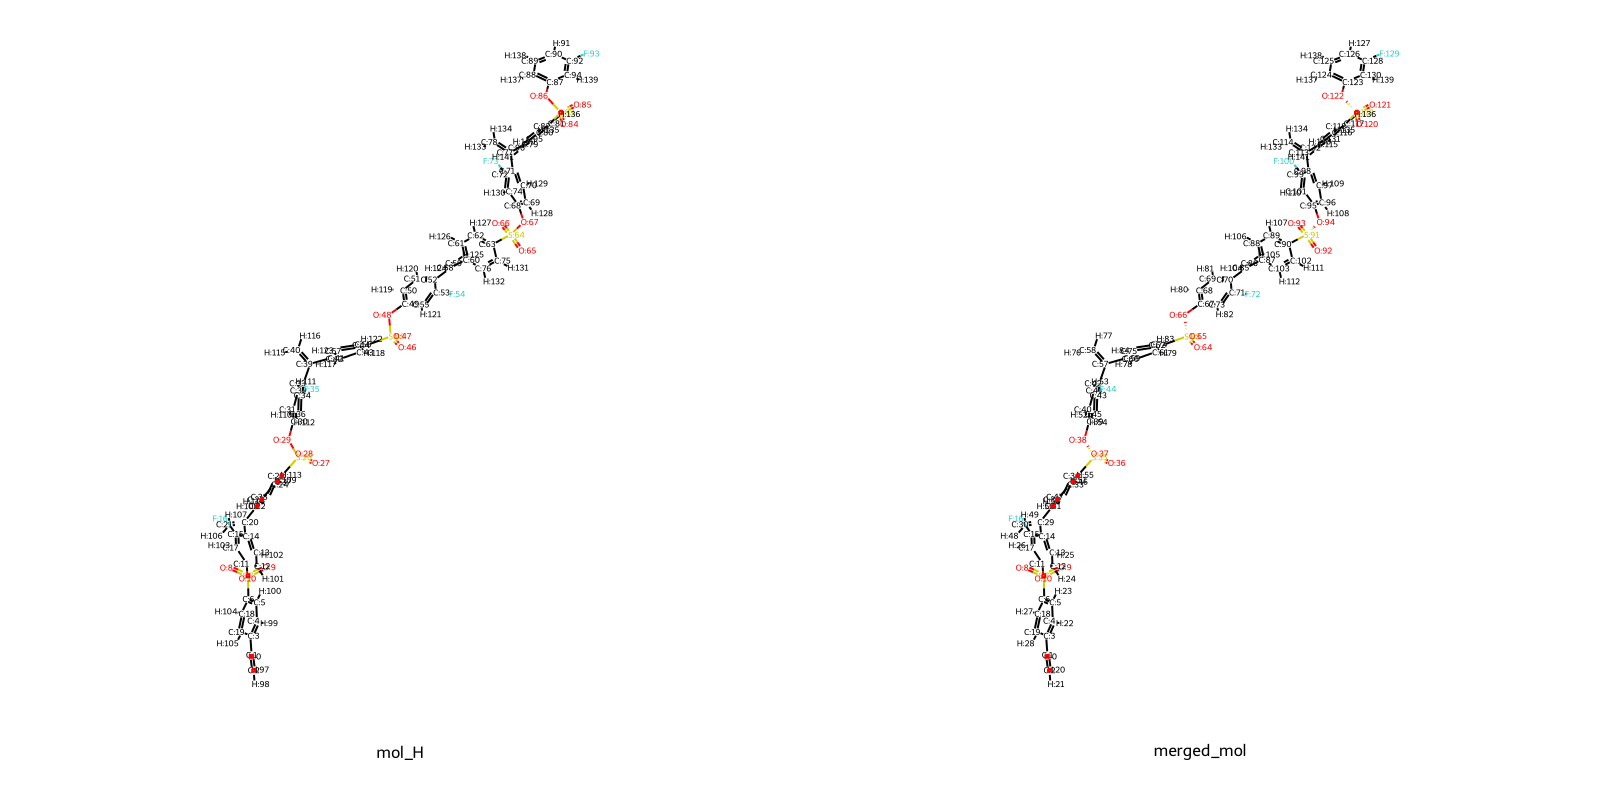

In [6]:
from rdkit import Chem
from rdkit.Chem import Draw
mol_H  = Chem.MolFromMolFile(sdf_file, removeHs=False)  # 保留H

def annotate_atoms(mol):
    mol = Chem.Mol(mol)  # 拷贝
    for atom in mol.GetAtoms():
        atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))
    return mol

mol_H_annot = annotate_atoms(mol_H)
merged_mol_annot = annotate_atoms(merged_mol)

img = Draw.MolsToGridImage(
    [mol_H_annot, merged_mol_annot],
    molsPerRow=2,
    subImgSize=(800, 800),
    legends=["mol_H", "merged_mol"]
)
from collections import Counter
from rdkit import Chem

# 假设 mol_H 和 merged_mol 已经被定义为 rdkit.Chem.Mol 对象

for name, mol in [('mol_H', mol_H), ('merged_mol', merged_mol)]:
    # 原子总数
    num_atoms = mol.GetNumAtoms()
    # 键列表
    bonds = list(mol.GetBonds())
    # 键总数
    num_bonds = len(bonds)
    # 各类型键的数量统计
    bond_types = Counter(bond.GetBondType() for bond in bonds)
    # 不同键类型数量（即有几种不同的键）
    num_distinct_types = len(bond_types)

    print(f"{name}:")
    print(f"  原子总数         = {num_atoms}")
    print(f"  键总数           = {num_bonds}")
    print(f"  不同键类型数量   = {num_distinct_types}")
    print(f"  各类型键的分布：")
    for btype, count in bond_types.items():
        # btype 会以 BondType.SINGLE、BondType.DOUBLE 等形式显示
        print(f"    {btype}: {count}")
    print()

img

In [7]:
mol_noH = Chem.RemoveAllHs(mol_H)
merged_mol_noH = Chem.RemoveAllHs(merged_mol)
img_noH = Draw.MolsToGridImage(
    [mol_noH, merged_mol_noH],)
from rdkit.Chem import rdMolAlign

rmsd = rdMolAlign.GetBestRMS(mol_noH, merged_mol_noH)
print(f"RMSD between mol_noH and merged_mol_noH: {rmsd:.4f} Å")

RMSD between mol_noH and merged_mol_noH: 0.0001 Å
